In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D, UpSampling1D
from keras.optimizers import Adam, RMSprop, SGD
from sklearn.cross_validation import KFold
import matplotlib.cm as cm
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.cross_validation import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import scipy.io

Using TensorFlow backend.
/home/nikos/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Setting the random seeds
random.seed(1)
np.random.seed(1337)

In [3]:
def load_data(filepath):

# Description: This function is responsible for loading our data.
# Args in: filepath - the path of the .mat file containing the data
# Returns: inputs - the data, labels - the labels corresponding to the data, 
#            patients - the patients corresponding to the data

    mat = scipy.io.loadmat(filepath)
    inputs_train_folds = mat['X_train_cell']
    labels_train_folds = mat['Y_train_cell']
    patients_train_folds = mat['patientID_train_cell']
    
    inputs_val_folds = mat['X_val_cell']
    labels_val_folds = mat['Y_val_cell']
    patients_val_folds = mat['patientID_val_cell']

    return inputs_train_folds, labels_train_folds, patients_train_folds, inputs_val_folds, labels_val_folds, patients_val_folds

In [4]:
inputs_train_folds, labels_train_folds, patients_train_folds, inputs_val_folds, labels_val_folds, patients_val_folds = load_data('/home/nikos/Desktop/DeepFrailtyPrediction/FS_Train_TestSets.mat')

In [5]:
def get_train_test_per_fold(inputs_train_folds, labels_train_folds, patients_train_folds, 
                            inputs_val_folds, labels_val_folds, patients_val_folds, fold_num):

    # Description: This function is responsible for loading our data.
    # Args in: filepath - the path of the .mat file containing the data
    # Returns: inputs - the data, labels - the labels corresponding to the data, 
    #            patients - the patients corresponding to the data
    
    print(patients_train_folds)

    inputs_train_folds = np.squeeze(inputs_train_folds)
    inputs_train = np.empty((inputs_train_folds[fold_num].shape[0], inputs_train_folds[fold_num].shape[1]))
    print(inputs_train_folds[fold_num].shape)
    #for i in range(inputs_train.shape[0]):
    inputs_train = inputs_train_folds[fold_num]
            
    labels_train_folds = np.squeeze(labels_train_folds)
    labels_train = np.empty((labels_train_folds[fold_num].shape[0], labels_train_folds[fold_num].shape[1]))
    print(labels_train_folds[fold_num].shape)
    #for i in range(labels_train.shape[0]):
    labels_train = labels_train_folds[fold_num]
        
    patients_train_folds = np.squeeze(patients_train_folds)
    patients_train = np.empty((patients_train_folds.shape[0], patients_train_folds[fold_num].shape[0], inputs_train_folds[fold_num].shape[1]))
    print(patients_train_folds[fold_num].shape)
    #for i in range(patients_train.shape[0]):
    patients_train = patients_train_folds[fold_num]
    
    inputs_val_folds = np.squeeze(inputs_val_folds)
    inputs_val = np.empty((inputs_val_folds[fold_num].shape[0], inputs_val_folds[fold_num].shape[1]))
    print(inputs_val_folds[fold_num].shape)
    #for i in range(inputs_train.shape[0]):
    inputs_val = inputs_val_folds[fold_num]
            
    labels_val_folds = np.squeeze(labels_val_folds)
    labels_val = np.empty((labels_val_folds.shape[0], labels_val_folds[fold_num].shape[0], labels_val_folds[fold_num].shape[1]))
    print(labels_val_folds[fold_num].shape)
    #for i in range(labels_train.shape[0]):
    labels_val = labels_val_folds[fold_num]
        
    patients_val_folds = np.squeeze(patients_val_folds)
    patients_val = np.empty((patients_val_folds.shape[0], patients_val_folds[fold_num].shape[0], patients_val_folds[fold_num].shape[1]))
    print(patients_val_folds[fold_num].shape)
    #for i in range(patients_train.shape[0]):
    patients_val = patients_val_folds[fold_num]
    

    return inputs_train, labels_train, patients_train, inputs_val, labels_val, patients_val

In [6]:
from sklearn.preprocessing import StandardScaler
def preprocess_data(X_train, X_val):

    # Description: This function preprocesses our data. 
    # We want to ensure that our training data have zero mean and unit variance. 
    # We also use subtract the same mean from the test data and then devide them by
    # the same standard deviation. We do that to ensure that no information about the
    # test set distribution is known ahead of time.

    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    
    return X_train, X_val

In [7]:
def one_hot(labels, n_class = 6):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = []
    for i in labels:
        y.append(expansion[int(i)])
    y = np.asarray(y)

    return y

In [8]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import keras.backend as K
#from sklearn.metrics import balanced_accuracy_score

class BalancedAccuracy(Callback):
    def __init__(self, train_data, validation_data):
        super(BalancedAccuracy, self).__init__()
        self.acas = []
        self.validation_data = validation_data
        self.train_data = train_data
        
    def on_epoch_end(self, epoch, logs={}):

        X_val = self.validation_data[0]
        y_val = self.validation_data[1]

        X_train = self.train_data[0]
        y_train = self.train_data[1]

        y_val_pred = self.model.predict(X_val)
        y_train_pred = self.model.predict(X_train)

        val_score = self.eval_avg_class_acc(y_val, y_val_pred)
        
        print("\nBalanced Accuracy - val: %.3f"%(val_score))        
        
    def eval_avg_class_acc(self, y_true, y_pred):

        # decode one-hot to single labels
        y_pred = y_pred.round()
        y_pred = [ np.argmax(pred, axis = 0) for pred in y_pred ]
        y_true = [ np.argmax(label, axis = 0) for label in y_true ]

        cf = confusion_matrix(y_true, y_pred)

        class0_acc = float(cf[0][0]) / (float(cf[0][0]) + float(cf[0][1]) + float(cf[0][2]))
        class1_acc = float(cf[1][1]) / (float(cf[1][1]) + float(cf[1][0]) + float(cf[1][2]))
        class2_acc = float(cf[2][2]) / (float(cf[2][2]) + float(cf[2][0]) + float(cf[2][1]))
        balanced_acc = float((class0_acc + class1_acc + class2_acc) / 3)

        return balanced_acc

def weighted_categorical_crossentropy(y_true, y_pred, weights):
    
    weights = K.variable(weights)
        
    # scale predictions so that the class probas of each sample sum to 1
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    # clip to prevent NaN's and Inf's
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # calc
    loss = y_true * K.log(y_pred) * weights
    loss = -K.sum(loss, -1)
    return loss

In [9]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [10]:
def visualize_results(history, model, X_train, y_train_one_hot, X_val, y_val_one_hot):
    print(history.history["acc"][-1])

    # TRAIN SET
    preds = model.predict(X_train)

    # decode one-hot to single labels
    preds = [ np.argmax(pred, axis = 0) for pred in preds ]
    labels = [ np.argmax(label, axis = 0) for label in y_train_one_hot ]

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(labels, preds)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=["non-frail", "pre-frail", "frail"], normalize=True,
                          title='Normalized confusion matrix - Train set - MLP on Raw Data')

    # TEST SET
    preds = model.predict(X_val)

    # decode one-hot to single labels
    preds = [ np.argmax(pred, axis = 0) for pred in preds ]
    labels = [ np.argmax(label, axis = 0) for label in y_val_one_hot ]

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(labels, preds)

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=["non-frail", "pre-frail", "frail"], normalize=True,
                          title='Normalized confusion matrix - Test set - MLP on Raw Data')

    plt.show()

In [11]:
def show_results_per_patient(X_val, y_val_one_hot, patients_val, model):
    y_pred = model.predict(X_val)
    y_pred = y_pred.round()
    y_pred = [ np.argmax(pred, axis = 0) for pred in y_pred ]
    y_true = [ np.argmax(label, axis = 0) for label in y_val_one_hot ]
    
    unique, counts = np.unique(patients_val, return_counts=True)
    unique_occurences = dict(zip(unique, counts))
    
    unique_patients = np.unique(patients_val)
    patient_dict = dict.fromkeys(unique_patients)
    majority_voting_dict = dict.fromkeys(unique_patients)
    
    for patient in patient_dict:
        patient_dict[patient] = [0, unique_occurences[patient], 0]
        majority_voting_dict[patient] = [0, 0, 0]
        
    for i in range(0, len(y_pred)):
        if y_pred[i] == y_true[i]:
            patient_dict[patients_val[i]][0] += 1
            patient_dict[patients_val[i]][2] = y_true[i]
        
        majority_voting_dict[patients_val[i]][y_pred[i]] += 1
                
            
    print(patient_dict)
            
    for patient in patient_dict:
        print("Displaying results for patient %d - Accuracy: %.2f"%(patient, float(patient_dict[patient][0]) / float(patient_dict[patient][1])))
    
    total_successfully_classified_patients = 0
    successfully_classified_patients = [0, 0, 0]
    total_patients = [0, 0, 0]
    
    for patient in patient_dict:
        majority_value =  max(majority_voting_dict[patient])
        if patient_dict[patient][0] == majority_value:
            total_successfully_classified_patients += 1
            successfully_classified_patients[patient_dict[patient][2]] += 1
            
        total_patients[patient_dict[patient][2]] += 1
            
    balanced_majority_voting = (float(successfully_classified_patients[0]) / float(total_patients[0]) + float(successfully_classified_patients[1]) / float(total_patients[1]) + float(successfully_classified_patients[2]) / float(total_patients[2])) / 3.0
    print("Displaying majority voting accuracy for the current fold {0}".format(float(total_successfully_classified_patients) / float(len(patient_dict))))
    print("Displaying majority voting balanced accuracy for the current fold {0}".format(balanced_majority_voting))
    
    return balanced_majority_voting

In [12]:
def collapse_2nd_dimension(labels_train, patients_train, labels_val, patients_val):   
    labels_train = np.einsum('ij->ji', labels_train)
    labels_train = [label_train for sublist in labels_train for label_train in sublist]
    patients_train = np.einsum('ij->ji', patients_train)
    patients_train = [patient_train for sublist in patients_train for patient_train in sublist]
    
    labels_val = np.einsum('ij->ji', labels_val)
    labels_val = [label_val for sublist in labels_val for label_val in sublist]
    patients_val = np.einsum('ij->ji', patients_val)
    patients_val = [patient_val for sublist in patients_val for patient_val in sublist]
    
    return np.asarray(labels_train), np.asarray(patients_train), np.asarray(labels_val), np.asarray(patients_val)

(17876, 60)
(17876, 1)
(17876, 1)
(1368, 60)
(1368, 1)
(1368, 1)


/home/nikos/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:43: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, input_shape=(60,), kernel_initializer="uniform")`


Train on 17876 samples, validate on 1368 samples
Epoch 1/300
 - 1s - loss: 2.8393 - acc: 0.5591 - val_loss: 4.2091 - val_acc: 0.3918

Balanced Accuracy - val: 0.411
Epoch 2/300
 - 1s - loss: 1.9413 - acc: 0.6967 - val_loss: 3.8738 - val_acc: 0.5548

Balanced Accuracy - val: 0.501
Epoch 3/300
 - 1s - loss: 1.7004 - acc: 0.7361 - val_loss: 3.5249 - val_acc: 0.6016

Balanced Accuracy - val: 0.534
Epoch 4/300
 - 1s - loss: 1.5068 - acc: 0.7676 - val_loss: 3.5986 - val_acc: 0.6287

Balanced Accuracy - val: 0.577
Epoch 5/300
 - 1s - loss: 1.3756 - acc: 0.7913 - val_loss: 3.4565 - val_acc: 0.6469

Balanced Accuracy - val: 0.597
Epoch 6/300
 - 1s - loss: 1.3183 - acc: 0.7966 - val_loss: 3.2649 - val_acc: 0.6586

Balanced Accuracy - val: 0.623
Epoch 7/300
 - 1s - loss: 1.2400 - acc: 0.8109 - val_loss: 3.3638 - val_acc: 0.6345

Balanced Accuracy - val: 0.603
Epoch 8/300
 - 1s - loss: 1.1819 - acc: 0.8203 - val_loss: 3.0759 - val_acc: 0.6652

Balanced Accuracy - val: 0.624
Epoch 9/300
 - 1s - los

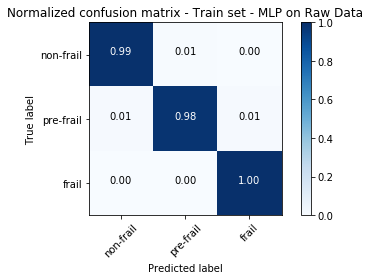

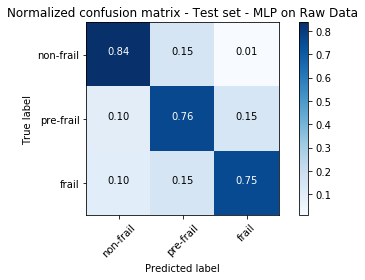

{1007: [2, 2, 0], 1017: [5, 9, 1], 1093: [333, 354, 0], 1119: [2, 3, 1], 2094: [324, 440, 2], 2102: [16, 20, 1], 3070: [30, 58, 0], 3117: [1, 21, 0], 3525: [2, 7, 1], 3578: [253, 325, 1], 3592: [94, 129, 1]}
Displaying results for patient 1007 - Accuracy: 1.00
Displaying results for patient 1017 - Accuracy: 0.56
Displaying results for patient 1093 - Accuracy: 0.94
Displaying results for patient 1119 - Accuracy: 0.67
Displaying results for patient 2094 - Accuracy: 0.74
Displaying results for patient 2102 - Accuracy: 0.80
Displaying results for patient 3070 - Accuracy: 0.52
Displaying results for patient 3117 - Accuracy: 0.05
Displaying results for patient 3525 - Accuracy: 0.29
Displaying results for patient 3578 - Accuracy: 0.78
Displaying results for patient 3592 - Accuracy: 0.73
Displaying majority voting accuracy for the current fold 0.8181818181818182
Displaying majority voting balanced accuracy for the current fold 0.8611111111111112
(16603, 60)
(16603, 1)
(16603, 1)
(2641, 60)
(26

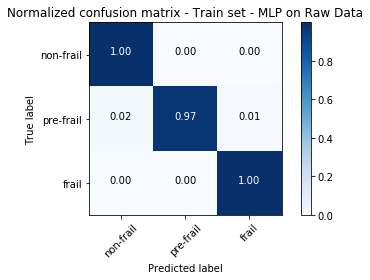

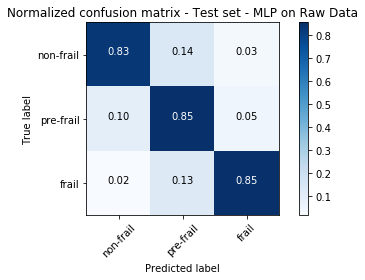

{1005: [2, 3, 1], 1092: [24, 28, 0], 1100: [162, 194, 1], 1103: [387, 479, 0], 1108: [490, 543, 0], 1109: [127, 135, 1], 1110: [24, 25, 1], 2005: [14, 19, 1], 2050: [284, 354, 0], 2092: [186, 231, 1], 2109: [525, 618, 2], 3062: [6, 12, 0]}
Displaying results for patient 1005 - Accuracy: 0.67
Displaying results for patient 1092 - Accuracy: 0.86
Displaying results for patient 1100 - Accuracy: 0.84
Displaying results for patient 1103 - Accuracy: 0.81
Displaying results for patient 1108 - Accuracy: 0.90
Displaying results for patient 1109 - Accuracy: 0.94
Displaying results for patient 1110 - Accuracy: 0.96
Displaying results for patient 2005 - Accuracy: 0.74
Displaying results for patient 2050 - Accuracy: 0.80
Displaying results for patient 2092 - Accuracy: 0.81
Displaying results for patient 2109 - Accuracy: 0.85
Displaying results for patient 3062 - Accuracy: 0.50
Displaying majority voting accuracy for the current fold 1.0
Displaying majority voting balanced accuracy for the current fo

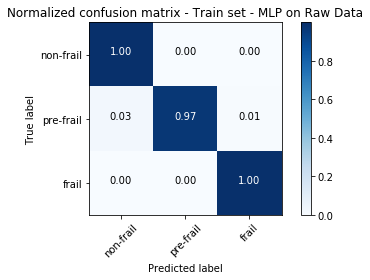

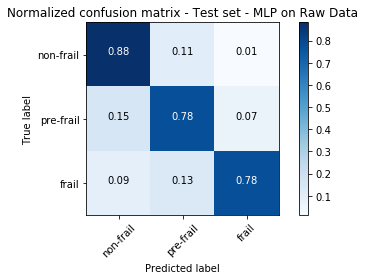

{1049: [6, 7, 0], 1050: [20, 24, 0], 1115: [39, 42, 0], 1510: [263, 267, 0], 1558: [2, 2, 1], 2091: [121, 173, 1], 2103: [135, 143, 1], 2113: [377, 532, 1], 3034: [126, 168, 1], 3035: [34, 45, 2], 3550: [222, 279, 0], 3601: [68, 70, 1]}
Displaying results for patient 1049 - Accuracy: 0.86
Displaying results for patient 1050 - Accuracy: 0.83
Displaying results for patient 1115 - Accuracy: 0.93
Displaying results for patient 1510 - Accuracy: 0.99
Displaying results for patient 1558 - Accuracy: 1.00
Displaying results for patient 2091 - Accuracy: 0.70
Displaying results for patient 2103 - Accuracy: 0.94
Displaying results for patient 2113 - Accuracy: 0.71
Displaying results for patient 3034 - Accuracy: 0.75
Displaying results for patient 3035 - Accuracy: 0.76
Displaying results for patient 3550 - Accuracy: 0.80
Displaying results for patient 3601 - Accuracy: 0.97
Displaying majority voting accuracy for the current fold 1.0
Displaying majority voting balanced accuracy for the current fold 

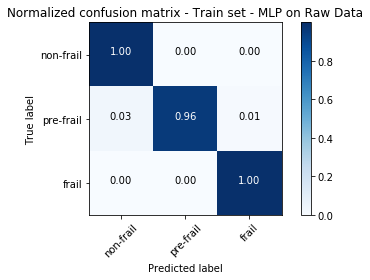

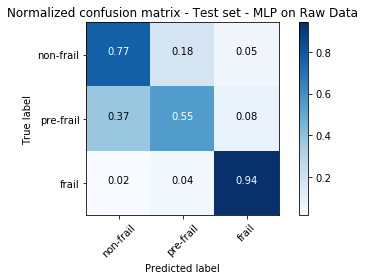

{1013: [1, 1, 1], 1027: [13, 65, 1], 1035: [16, 93, 0], 1047: [1, 1, 1], 1059: [1, 4, 1], 1086: [3, 3, 0], 1102: [57, 66, 0], 1514: [164, 166, 0], 2081: [114, 172, 1], 2087: [89, 95, 0], 2105: [3, 6, 1], 2584: [254, 271, 2]}
Displaying results for patient 1013 - Accuracy: 1.00
Displaying results for patient 1027 - Accuracy: 0.20
Displaying results for patient 1035 - Accuracy: 0.17
Displaying results for patient 1047 - Accuracy: 1.00
Displaying results for patient 1059 - Accuracy: 0.25
Displaying results for patient 1086 - Accuracy: 1.00
Displaying results for patient 1102 - Accuracy: 0.86
Displaying results for patient 1514 - Accuracy: 0.99
Displaying results for patient 2081 - Accuracy: 0.66
Displaying results for patient 2087 - Accuracy: 0.94
Displaying results for patient 2105 - Accuracy: 0.50
Displaying results for patient 2584 - Accuracy: 0.94
Displaying majority voting accuracy for the current fold 0.75
Displaying majority voting balanced accuracy for the current fold 0.822222222

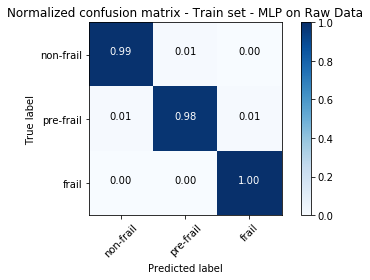

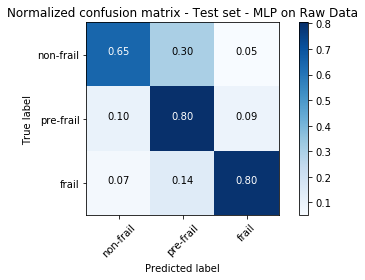

{1006: [3, 5, 0], 1042: [116, 126, 0], 1052: [9, 16, 1], 1056: [1, 2, 2], 1095: [79, 81, 0], 2057: [10, 14, 1], 2085: [608, 751, 1], 2090: [177, 194, 1], 2097: [577, 735, 2], 3043: [37, 77, 1], 3106: [45, 166, 0], 3113: [14, 17, 0]}
Displaying results for patient 1006 - Accuracy: 0.60
Displaying results for patient 1042 - Accuracy: 0.92
Displaying results for patient 1052 - Accuracy: 0.56
Displaying results for patient 1056 - Accuracy: 0.50
Displaying results for patient 1095 - Accuracy: 0.98
Displaying results for patient 2057 - Accuracy: 0.71
Displaying results for patient 2085 - Accuracy: 0.81
Displaying results for patient 2090 - Accuracy: 0.91
Displaying results for patient 2097 - Accuracy: 0.79
Displaying results for patient 3043 - Accuracy: 0.48
Displaying results for patient 3106 - Accuracy: 0.27
Displaying results for patient 3113 - Accuracy: 0.82
Displaying majority voting accuracy for the current fold 0.9166666666666666
Displaying majority voting balanced accuracy for the cu

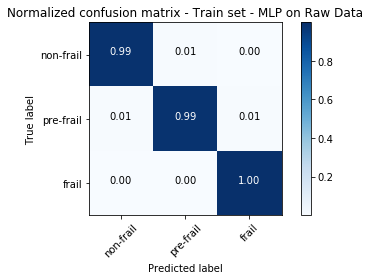

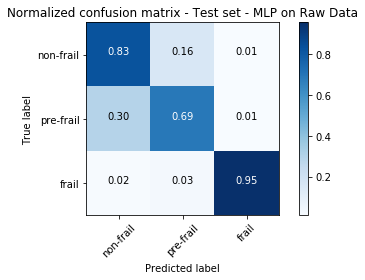

{1002: [66, 543, 1], 1057: [4, 5, 1], 1106: [561, 645, 0], 1113: [4, 4, 0], 2082: [129, 147, 2], 2095: [140, 171, 1], 2110: [940, 970, 1], 2116: [237, 239, 2], 3006: [52, 69, 0], 3082: [23, 37, 0], 3085: [47, 53, 1], 3095: [26, 48, 0]}
Displaying results for patient 1002 - Accuracy: 0.12
Displaying results for patient 1057 - Accuracy: 0.80
Displaying results for patient 1106 - Accuracy: 0.87
Displaying results for patient 1113 - Accuracy: 1.00
Displaying results for patient 2082 - Accuracy: 0.88
Displaying results for patient 2095 - Accuracy: 0.82
Displaying results for patient 2110 - Accuracy: 0.97
Displaying results for patient 2116 - Accuracy: 0.99
Displaying results for patient 3006 - Accuracy: 0.75
Displaying results for patient 3082 - Accuracy: 0.62
Displaying results for patient 3085 - Accuracy: 0.89
Displaying results for patient 3095 - Accuracy: 0.54
Displaying majority voting accuracy for the current fold 0.9166666666666666
Displaying majority voting balanced accuracy for the

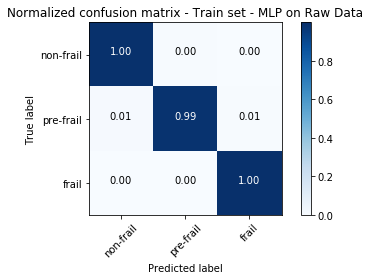

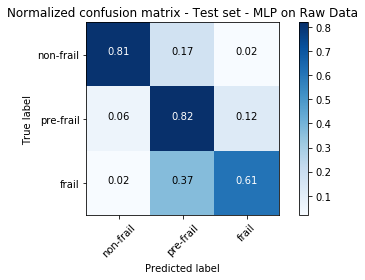

{1044: [9, 15, 0], 1063: [14, 26, 2], 1107: [9, 13, 1], 1114: [333, 360, 0], 1120: [8, 9, 1], 2006: [16, 23, 2], 2107: [67, 68, 1], 3076: [162, 241, 0], 3086: [29, 43, 0], 3087: [40, 40, 0], 3098: [71, 83, 1], 3559: [24, 47, 1]}
Displaying results for patient 1044 - Accuracy: 0.60
Displaying results for patient 1063 - Accuracy: 0.54
Displaying results for patient 1107 - Accuracy: 0.69
Displaying results for patient 1114 - Accuracy: 0.93
Displaying results for patient 1120 - Accuracy: 0.89
Displaying results for patient 2006 - Accuracy: 0.70
Displaying results for patient 2107 - Accuracy: 0.99
Displaying results for patient 3076 - Accuracy: 0.67
Displaying results for patient 3086 - Accuracy: 0.67
Displaying results for patient 3087 - Accuracy: 1.00
Displaying results for patient 3098 - Accuracy: 0.86
Displaying results for patient 3559 - Accuracy: 0.51
Displaying majority voting accuracy for the current fold 1.0
Displaying majority voting balanced accuracy for the current fold 1.0
(164

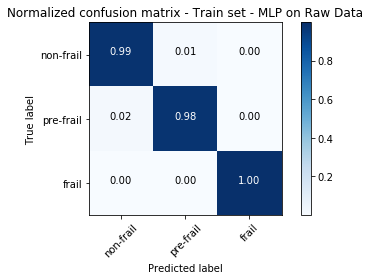

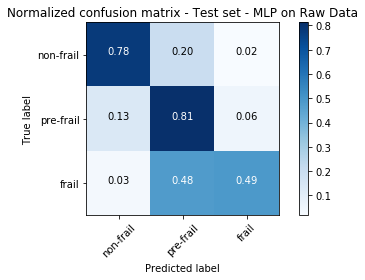

{1003: [242, 290, 1], 1053: [19, 27, 0], 1091: [15, 16, 0], 1104: [196, 420, 2], 1118: [581, 744, 0], 2073: [46, 152, 1], 2101: [613, 707, 1], 2108: [224, 259, 0], 3026: [28, 32, 1], 3099: [42, 60, 0], 3593: [111, 120, 1]}
Displaying results for patient 1003 - Accuracy: 0.83
Displaying results for patient 1053 - Accuracy: 0.70
Displaying results for patient 1091 - Accuracy: 0.94
Displaying results for patient 1104 - Accuracy: 0.47
Displaying results for patient 1118 - Accuracy: 0.78
Displaying results for patient 2073 - Accuracy: 0.30
Displaying results for patient 2101 - Accuracy: 0.87
Displaying results for patient 2108 - Accuracy: 0.86
Displaying results for patient 3026 - Accuracy: 0.88
Displaying results for patient 3099 - Accuracy: 0.70
Displaying results for patient 3593 - Accuracy: 0.93
Displaying majority voting accuracy for the current fold 0.9090909090909091
Displaying majority voting balanced accuracy for the current fold 0.9333333333333332
(17199, 60)
(17199, 1)
(17199, 1)

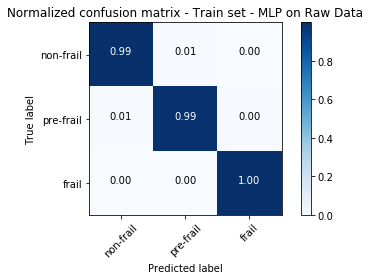

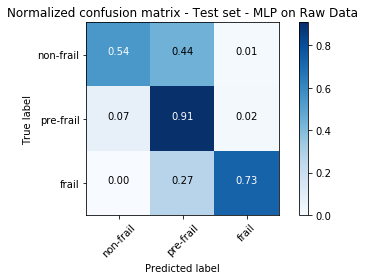

{1054: [35, 52, 2], 1099: [19, 27, 0], 2070: [12, 12, 1], 2083: [16, 19, 1], 2089: [358, 406, 1], 2100: [460, 480, 1], 2119: [199, 282, 0], 3039: [106, 298, 0], 3052: [9, 18, 0], 3104: [99, 155, 0], 3112: [249, 296, 1]}
Displaying results for patient 1054 - Accuracy: 0.67
Displaying results for patient 1099 - Accuracy: 0.70
Displaying results for patient 2070 - Accuracy: 1.00
Displaying results for patient 2083 - Accuracy: 0.84
Displaying results for patient 2089 - Accuracy: 0.88
Displaying results for patient 2100 - Accuracy: 0.96
Displaying results for patient 2119 - Accuracy: 0.71
Displaying results for patient 3039 - Accuracy: 0.36
Displaying results for patient 3052 - Accuracy: 0.50
Displaying results for patient 3104 - Accuracy: 0.64
Displaying results for patient 3112 - Accuracy: 0.84
Displaying majority voting accuracy for the current fold 0.9090909090909091
Displaying majority voting balanced accuracy for the current fold 0.9333333333333332
(17659, 60)
(17659, 1)
(17659, 1)
(1

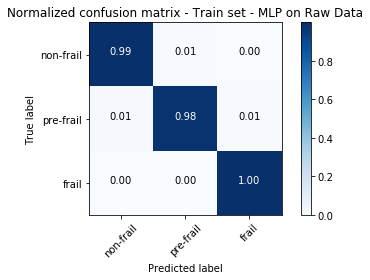

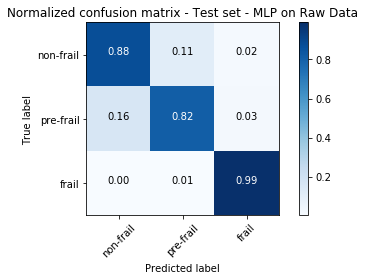

{1012: [25, 34, 0], 1090: [84, 145, 1], 1094: [44, 50, 1], 1098: [3, 7, 0], 1101: [107, 110, 1], 2098: [430, 503, 1], 2104: [292, 296, 2], 2111: [66, 75, 0], 2615: [298, 330, 0], 3033: [4, 5, 0], 3084: [19, 30, 1]}
Displaying results for patient 1012 - Accuracy: 0.74
Displaying results for patient 1090 - Accuracy: 0.58
Displaying results for patient 1094 - Accuracy: 0.88
Displaying results for patient 1098 - Accuracy: 0.43
Displaying results for patient 1101 - Accuracy: 0.97
Displaying results for patient 2098 - Accuracy: 0.85
Displaying results for patient 2104 - Accuracy: 0.99
Displaying results for patient 2111 - Accuracy: 0.88
Displaying results for patient 2615 - Accuracy: 0.90
Displaying results for patient 3033 - Accuracy: 0.80
Displaying results for patient 3084 - Accuracy: 0.63
Displaying majority voting accuracy for the current fold 0.9090909090909091
Displaying majority voting balanced accuracy for the current fold 0.9333333333333332


In [13]:
from functools import partial
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers import Activation, BatchNormalization, Reshape
from keras.layers import Dropout
import tensorflow as tf 

for i in range(0,10):
    X_train, y_train, patients_train, X_val, y_val, patients_val = get_train_test_per_fold(inputs_train_folds, labels_train_folds, patients_train_folds, 
                            inputs_val_folds, labels_val_folds, patients_val_folds, i)
    
    y_train, patients_train, y_val, patients_val = collapse_2nd_dimension(y_train, patients_train, y_val, patients_val)
    

    # Weighted loss function to tackle class imbalance in the dataset

    weights = np.array([float(len(y_train)) / float(list(y_train).count(0)), float(len(y_train)) / float(list(y_train).count(1)), float(len(y_train)) / float(list(y_train).count(2))])
    w_cat_crossentropy = partial(weighted_categorical_crossentropy, weights = weights)
    w_cat_crossentropy.__name__ = 'weighted_categorical_crossentropy'
    
    # Balanced accuracy metric definition
    balanced_accuracy = BalancedAccuracy(train_data = (X_train, y_train), validation_data = (X_val, y_val))
    CALLBACKS = [balanced_accuracy]
    
    # Data preprocessing
    X_train, X_val = preprocess_data(X_train, X_val)
    
    
    # Shuffle inputs and labels
    c = list(zip(X_train, y_train, patients_train))
    random.shuffle(c)
    X_train, y_train, patients_train = zip(*c)

    c = list(zip(X_val, y_val, patients_val))
    random.shuffle(c)
    X_val, y_val, patients_val = zip(*c)

    X_train = np.asarray(X_train)
    X_val = np.asarray(X_val)
    
    
    model = Sequential()
    model.add(Dense(256, init='uniform', input_shape = (X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, kernel_initializer="uniform"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = 'softmax'))

    adam = Adam(lr = 0.01)
    y_train_one_hot = one_hot(y_train, 3)
    y_val_one_hot = one_hot(y_val, 3)

    model.compile(loss=w_cat_crossentropy, optimizer=adam, metrics=['accuracy'])

    history = model.fit(X_train, y_train_one_hot, epochs=300, batch_size=512, validation_data=(X_val, y_val_one_hot), 
              verbose=2, shuffle=True, callbacks=CALLBACKS)
    
    visualize_results(history, model, X_train, y_train_one_hot, X_val, y_val_one_hot)
    
    show_results_per_patient(X_val, y_val_one_hot, patients_val, model)

In [13]:
def get_train_val_test_per_fold(inputs_train_folds, labels_train_folds, patients_train_folds, 
                            inputs_val_folds, labels_val_folds, patients_val_folds, val_patients_per_fold, fold_num):

    # Description: This function is responsible for loading our data.
    # Args in: filepath - the path of the .mat file containing the data
    # Returns: inputs - the data, labels - the labels corresponding to the data, 
    #            patients - the patients corresponding to the data

    inputs_train_folds = np.squeeze(inputs_train_folds)
    inputs_train = np.empty((inputs_train_folds[fold_num].shape[0], inputs_train_folds[fold_num].shape[1]))
    print(inputs_train_folds[fold_num].shape)
    #for i in range(inputs_train.shape[0]):
    inputs_train = inputs_train_folds[fold_num]
            
    labels_train_folds = np.squeeze(labels_train_folds)
    labels_train = np.empty((labels_train_folds[fold_num].shape[0], labels_train_folds[fold_num].shape[1]))
    print(labels_train_folds[fold_num].shape)
    #for i in range(labels_train.shape[0]):
    labels_train = labels_train_folds[fold_num]
        
    patients_train_folds = np.squeeze(patients_train_folds)
    patients_train = np.empty((patients_train_folds.shape[0], patients_train_folds[fold_num].shape[0], inputs_train_folds[fold_num].shape[1]))
    print(patients_train_folds[fold_num].shape)
    #for i in range(patients_train.shape[0]):
    patients_train = patients_train_folds[fold_num]

    patients_val_indices = []
    patient_array = patients_val_folds[fold_num][0].flatten()
    for patient_id in val_patients_per_fold[fold_num]:
        for index in range(patient_array.shape[0]):
            if patient_id == patient_array[index]:
                patients_val_indices.append(index)
        
    #print(patients_val_indices)
    
    patients_val_folds = np.squeeze(patients_val_folds)
    patients_val = np.empty((patients_val_folds.shape[0], patients_val_folds[fold_num].shape[0], patients_val_folds[fold_num].shape[1]))
    patients_val = patients_val_folds[fold_num]
    
    patients_val_new = [patients_val[i][0] for i in patients_val_indices]
    patients_test = [patients_val[i][0] for i in range(patient_array.shape[0]) if i not in patients_val_indices]
    patients_val = patients_val_new
    patients_test = np.asarray(patients_test)
    patients_val = np.asarray(patients_val)
    #print(patients_test)
    #print(patients_val)
    
    inputs_val_folds = np.squeeze(inputs_val_folds)
    inputs_val = np.empty((inputs_val_folds[fold_num].shape[0], inputs_val_folds[fold_num].shape[1]))
    inputs_val = inputs_val_folds[fold_num]
    
    inputs_val_new = [inputs_val[i] for i in patients_val_indices]
    inputs_test = [inputs_val[i] for i in range(patient_array.shape[0]) if i not in patients_val_indices]
    inputs_val = inputs_val_new
    inputs_test = np.asarray(inputs_test)
    inputs_val = np.asarray(inputs_val)
    #print(inputs_test.shape)
    #print(inputs_val.shape)
            
    labels_val_folds = np.squeeze(labels_val_folds)
    labels_val = np.empty((labels_val_folds.shape[0], labels_val_folds[fold_num].shape[0], labels_val_folds[fold_num].shape[1]))
    labels_val = labels_val_folds[fold_num]
    
    labels_val_new = [labels_val[i][0] for i in patients_val_indices]
    labels_test = [labels_val[i][0] for i in range(patient_array.shape[0]) if i not in patients_val_indices]
    labels_val = labels_val_new
    labels_test = np.asarray(labels_test)
    labels_val = np.asarray(labels_val)
    #print(labels_test)
    #print(labels_val)
    

    return inputs_train, labels_train, patients_train, inputs_val, labels_val, patients_val, inputs_test, labels_test, patients_test

In [14]:
def preprocess_data2(X_train, X_val, X_test):

    # Description: This function preprocesses our data. 
    # We want to ensure that our training data have zero mean and unit variance. 
    # We also use subtract the same mean from the test data and then devide them by
    # the same standard deviation. We do that to ensure that no information about the
    # test set distribution is known ahead of time.

    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    return X_train, X_val, X_test

In [15]:
def collapse_2nd_dimension2(labels_train, patients_train):   
    labels_train = np.einsum('ij->ji', labels_train)
    labels_train = [label_train for sublist in labels_train for label_train in sublist]
    patients_train = np.einsum('ij->ji', patients_train)
    patients_train = [patient_train for sublist in patients_train for patient_train in sublist]

    return np.asarray(labels_train), np.asarray(patients_train)

In [16]:
inputs_train_folds, labels_train_folds, patients_train_folds, inputs_val_folds, labels_val_folds, patients_val_folds = load_data('/home/nikos/Desktop/DeepFrailtyPrediction/FS_Train_TestSets.mat')
    
val_patients_per_fold = dict.fromkeys([i for i in range(10)])
val_patients_per_fold[0] = [1007, 3070, 1017, 2102, 3525]
val_patients_per_fold[1] = [1092, 1108, 1005, 1109, 2005]
val_patients_per_fold[2] = [1049, 1115, 2091, 3034, 3601]
val_patients_per_fold[3] = [1013, 2081, 1059, 1035, 2087]
val_patients_per_fold[4] = [1006, 3106, 1052, 2085, 2097]
val_patients_per_fold[5] = [1002, 3006, 2095, 3085, 2116]
val_patients_per_fold[6] = [1044, 3076, 1107, 2107, 2006]
val_patients_per_fold[7] = [1003, 2101, 1091, 2108]
val_patients_per_fold[8] = [1099, 3039, 2070, 2100]
val_patients_per_fold[9] = [1012, 2111, 1090, 2098]

In [17]:
p = {'layers':['one', 'two', 'three'],
    'units1':[64, 128, 256, 512],
    'units2':[64, 128, 256, 512],
    'units3':[64, 128, 256, 512],
    'dropout1':[0.25,0.5,0.75],
     'dropout2':[0.25,0.5,0.75],
     'dropout3':[0.25,0.5,0.75],
     'batch_norm':['no', 'yes'],
     'batch_size':[16, 32, 64, 128, 256, 512],
     'lr':[0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1],
    }

In [18]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice

In [19]:
def model(X_train, y_train, X_val, y_val):
    
    weights = np.array([float(len(y_train)) / float(list(y_train).count(0)), float(len(y_train)) / float(list(y_train).count(1)), float(len(y_train)) / float(list(y_train).count(2))])
    w_cat_crossentropy = partial(weighted_categorical_crossentropy, weights = weights)
    w_cat_crossentropy.__name__ = 'weighted_categorical_crossentropy'
    
    # Balanced accuracy metric definition
    balanced_accuracy = BalancedAccuracy(train_data = (X_train, y_train), validation_data = (X_val, y_val))
    CALLBACKS = [balanced_accuracy]
    
    y_train_one_hot = one_hot(y_train, 3)
    y_val_one_hot = one_hot(y_val, 3)

    num_of_layers = {{choice(['one', 'two', 'three'])}}
    batch_norm = {{choice(['yes', 'no'])}}
    
    model = Sequential()
    model.add(Dense({{choice([64, 128, 256, 512])}}, init='uniform', input_shape = (X_train.shape[1],)))
    if batch_norm == 'yes':
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout({{choice([0.25,0.5,0.75])}}))
    
    if num_of_layers in ['two', 'three']:
        model.add(Dense({{choice([64, 128, 256, 512])}}, init='uniform'))
        if batch_norm == 'yes':
            model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout({{choice([0.25,0.5,0.75])}}))
        
    if num_of_layers == 'three':
        model.add(Dense({{choice([64, 128, 256, 512])}}, init='uniform'))
        if batch_norm == 'yes':
            model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout({{choice([0.25,0.5,0.75])}}))
    model.add(Dense(3, activation = 'softmax'))

    adam = Adam(lr = {{choice([0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1])}})
    y_train_one_hot = one_hot(y_train, 3)
    y_val_one_hot = one_hot(y_val, 3)

    model.compile(loss=w_cat_crossentropy, optimizer=adam, metrics=['accuracy'])

    history = model.fit(X_train, y_train_one_hot, epochs=50, batch_size={{choice([16, 32, 64, 128, 256, 512])}}, validation_data=(X_val, y_val_one_hot), 
              verbose=2, shuffle=True, callbacks=CALLBACKS)
    
    visualize_results(history, model, X_train, y_train_one_hot, X_val, y_val_one_hot)
    
    score = show_results_per_patient(X_val, y_val_one_hot, patients_val, model)
                  
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

In [28]:
def data():

In [29]:
from functools import partial
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers import Activation, BatchNormalization, Reshape
from keras.layers import Dropout

for i in range(0,10):
    
    X_train, y_train, patients_train, X_val, y_val, patients_val, X_test, y_test, patients_test = get_train_val_test_per_fold(inputs_train_folds, labels_train_folds, patients_train_folds, 
                            inputs_val_folds, labels_val_folds, patients_val_folds, val_patients_per_fold, i)
    
    y_train, patients_train = collapse_2nd_dimension2(y_train, patients_train)
        
    # Data preprocessing
    X_train, X_val, X_test = preprocess_data2(X_train, X_val, X_test)
    
    
    # Shuffle inputs and labels
    c = list(zip(X_train, y_train, patients_train))
    random.shuffle(c)
    X_train, y_train, patients_train = zip(*c)

    c = list(zip(X_val, y_val, patients_val))
    random.shuffle(c)
    X_val, y_val, patients_val = zip(*c)
    
    c = list(zip(X_test, y_test, patients_test))
    random.shuffle(c)
    X_test, y_test, patients_test = zip(*c)

    X_train = np.asarray(X_train)
    X_val = np.asarray(X_val)
    X_test = np.asarray(X_test)

    #y_train_one_hot = one_hot(y_train, 3)
    #y_val_one_hot = one_hot(y_val, 3)
    y_test_one_hot = one_hot(y_test, 3)
    
    y_train = np.asarray(y_train)
    y_val = np.asarray(y_val)
        
    best_run, best_model = optim.minimize(model=model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=5,
                                      trials=Trials(),
                                      notebook_name='kfoldFrailMLP')
    
    #visualize_results(history, model, X_train, y_train_one_hot, X_val, y_val_one_hot)
    
    #show_results_per_patient(X_val, y_val_one_hot, patients_val, model)

(17876, 60)
(17876, 1)
(17876, 1)
>>> Imports:
#coding=utf-8

try:
    import keras
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import random
except:
    pass

try:
    from sklearn.metrics import mean_squared_error
except:
    pass

try:
    from keras.models import Sequential, Model
except:
    pass

try:
    from keras.layers import Input, Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D, UpSampling1D
except:
    pass

try:
    from keras.optimizers import Adam, RMSprop, SGD
except:
    pass

try:
    from sklearn.cross_validation import KFold
except:
    pass

try:
    import matplotlib.cm as cm
except:
    pass

try:
    from sklearn.metrics import accuracy_score, mean_absolute_error
except:
    pass

try:
    from sklearn.cross_validation import train_test_split
except:
    pass

try:
    from sklearn.metrics.pairwise import cosine_similarity
except:
    pass

try:
    import scipy.io
excep

NameError: name 'collapse_2nd_dimension2' is not defined